# Tinkering Notebook - Function Approximation 

**Note**: If the environment `Cooridor-v0` does not work, you have to update the package `gym_RLcourse`. See Studium for instructions. 

**Tile Coding, IMPORTANT**: For the example with `MountainCar` we will use the tile coding as features. For this we will use the Python code described on http://incompleteideas.net/tiles/tiles3.html in the notebook. You thus have to download the code at http://incompleteideas.net/tiles/tiles3.py-remove (select all, copy and save in a file `TildeCoding.py` in the same folder as this Jupyter Notebook). You can also read more about tile coding in Chapter 9.5.4. in the textbook.

# Table of content
* ### [1. Imports](#sec1)
* ### [2. The corridor environment](#sec2)
* ### [3. Value-Function Approximation](#sec3)
 * #### [3.1 Linear Approximation with Polynomials and Fourier Basis ](#sec3_1)
 * #### [3.2 Monte-Carlo with value function approximation ](#sec3_2)
 * #### [3.3 Run the agent](#sec3_3)
 * #### [3.4 Discussions ](#sec3_4)
* ### [4. On-Policy Control with Function Approximation](#sec4)
 * #### [4.1 Linear Approximation with Tile Coding](#sec4_1)
 * #### [4.2 SARSA for Estimating Action-Value Function with Function Approximation](#sec4_2)
 * #### [4.3 The MountainCar Environment](#sec4_3)
 * #### [4.4 Discussions](#sec4_4)


# 1. Imports <a id="sec1">

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import gym_RLcourse
import pickle # used to read pickle data
import TildeCoding as tc
from IPython.display import clear_output # Used to clear the ouput of a Jupyter cell.

# 2. The corridor environment <a id="sec2">

In this notebook we will use the corridor environment described in Example 9.1 in the textbook. 

In [2]:
env = gym.make('Corridor-v0', n_starting_states=10, max_delta=2)
print('State space:', env.observation_space)
print('Action space:', env.action_space)

State space: Discrete(12)
Action space: Discrete(4)


**State Space:** There are `n_starting_states` non-terminal states, and two terminal states. 

**Action space:** You can go `max_delta` steps to the right or to the left, so there are in total `2*max_delta` actions.

**Rewards:** The reward is 0 except when you reach a terminal state. In the left terminal state you get -1 and in the right terminal state +1.

**Policy:** Below we will estimate the value function for this environment when the policy chooses between all actions with the same probability. 

Let's make a basic check on our installation for the corridor environment. When you run the code, you will see `n_starting_states` non-terminal states,  a terminal state on the left (TL) and another terminal state on the right (TR). Agent's location is indicated by `x` which is (approximately) halfway in the corridor at initialization. Other states are marked with o. 

In [3]:
state, info = env.reset()
env.render()

TL o  o  o  o  o  x  o  o  o  o  TR



# 3. Value-Function Approximation <a id="sec3">

We now consider the prediction problem using function approximation of the value function, $\hat{v}(s,w)$, with the goal of obtaining  $\hat{v}(s,w)\approx v_\pi(s)$. 

## 3.1 Linear Approximation with Polynomials and Fourier Basis  <a id="sec3_1">

We first implement a linear approximator that uses either  polynomials or Fourier basis as features. 
      
__Task-VA1:__ Below, variable `method` determines whether we use Fourier features or polynomial features. Compare `construct_basis` with the equations in Section 9.5.1 and Section 9.5.2 to understand how the features are implemented. The code uses `lambda` expressions, which is just another way to define functions. You can read about `lambda` expressions in Section 4.7.6 from here https://docs.python.org/3/tutorial/controlflow.html. With this implementation, we obtain a dictionary of basis functions which we can then evaluate for any value of state. 

__Task-VA2:__ Find which methods/variables in the code give the following: i)  $x(s)$ for a given state ii) $\hat{v}(s,w)$ for a given state. 
    
    
__Task-VA3:__ Complete the `update` function so that it implements Eqn. 9.7. Remember that for a linear function approximator $\hat{v}(s, w) = w^\top x(s)$ we get $\nabla \hat{v}(s,w) = x(s)$. (Also see the exercises on function approximation, where this is proven in an exercise).
   
__Task-VA4:__ In the implementation below, we have a variable called `StateRange` which normalizes the values of the states. Why do you think this is useful?



In [4]:
class LinearApproximator:

    def __init__(self, order, method="Fourier", alpha=1e-4, stateRange=1):
        self.alpha = alpha
        self.method = method
        self.order = order
        self.weights = np.zeros(order + 1)
        self.stateRange = stateRange
        self.construct_basis()
 
    def construct_basis(self):
        self.basis=[]
        if self.method == "Polynomial":
            for i in range(0, self.order + 1):
                self.basis += [lambda s, i=i: np.power(s, i)]
        if self.method == "Fourier":
            for i in range(0, self.order + 1):
                self.basis += [lambda s, i=i: np.cos(np.pi * s * i) ]

    # return the values of features for a given state 
    def features(self, state): 
        state = state / self.stateRange  # normalize to [0, 1]
        return np.array([f(state) for f in self.basis])

    # return the value of the approximation for the given state
    def value(self, state):  
        return np.dot(self.features(state), self.weights)

    # update the weights
    def update(self, target, state):  # update the weights using the eqn 9.7 where U_t is the target
        self.weights += self.alpha * (target - self.value(state))*self.features(state)  


## 3.2 Monte-Carlo with value function approximation  <a id="sec3_2">

We now implement the Gradient Monte Carlo Algorithm on Page 202 using a random policy (i.e. all possible actions have the same probability). 

In the below code we implement both the tabular method and function approximation. You can then choose method with 

* `method = "Tabular"` - gives the tabular method
* `method = "Fourier"` - gives function approximation with Fourier basis functions.
* `method = "Polynomial"` - gives function approximation with polynomial basis functions.

**Task-MC**: Implement the missing parts of the `learn` method which are marked with TODO-STD. Note that `self.func_approx` is a `LinearApproximator` and has the methods `self.func_approx.update()` and `self.func_approx.value()`.

In [5]:
class MCAgent:
    # Accepts 'plain' or any method that LinearApproximator accepts. If the method is 'plain',
    # no function approximation is performed. The 'plain' option is included for comparison purposes.
    
    def __init__(self, n_states, n_actions, gamma, method, order, alpha, stateRange):
        self.n_actions = n_actions
        self.V = np.zeros(n_states)
        self.S = np.zeros(n_states)
        self.N = np.zeros(n_states)
        self.n_states = n_states
        self.gamma = gamma
        self.method = method 
        self.func_approx = LinearApproximator(order, method, alpha, stateRange)

    def act(self, state):
        return np.random.choice(self.n_actions)
    
    def value(self, state):
        if self.method == "Tabular": 
            return self.V[state]
        else:
            return self.func_approx.value(state)

    def learn(self, states, actions, rewards):
        T = len(states) - 1
        if self.method == "Tabular":   #  function approximation is NOT performed
            G = 0
            for t in reversed(range(T)):
                G = self.gamma * G + rewards[t + 1]  # G_t
                self.N[states[t]] += 1
                self.V[states[t]] += 1 / self.N[states[t]] * (G - self.V[states[t]])
        else:  #  Function approximation is performed
            # TODO-STD 
            # Implement the last two lines of the MC-algorithm on page 202 in the textbook. 
            G=0  
            for i in reversed(range(T)): 
                G = self.gamma * G + rewards[i + 1] 
                self.func_approx.update(G, states[i]) 


## 3.3 Run the agent <a id="sec3_3">

We first create the environment that will be used for training. Since the training can take a long time if you use a large number of states and actions, we will first use `n_starting_states=100` and `max_delta=10`. When you are done experimenting, you can change this to `n_starting_states=1000` and `max_delta=100` to get the environment used in Example 9.1-9.2 and Figure 9.5 in the textbook. 

In [15]:
env = gym.make('Corridor-v0', n_starting_states=100, max_delta=10)

We then create an agent that uses function approximation with Fourier basis functions. 

In [30]:
stateRange = env.observation_space.n - 2 # Number of non-terminal states
# By changing method you can get "Tabular", "Fourier" or "Polynomial"
agent = MCAgent(env.observation_space.n, env.action_space.n, gamma=1, method="Polynomial", order=20, alpha=5e-5,
                stateRange=stateRange)

We now run the agent on the environment. __Note that this may take some time, wait until you see 'Finished'.__ 

In [31]:
nEpisode = 5000
max_nStep = int(2.0e6)
print('Run starts')
for iEpisode in range(1,nEpisode+1):
    if iEpisode % 500 == 0:
        print('Episode', iEpisode)
    state, info = env.reset()
    stateA = [state]
    action = agent.act(state)
    actionA = [action]
    rewardA = [0]
    terminated, truncated = False, False
    t_done = -1
    while not (terminated or truncated):
        state, reward, terminated, truncated, info = env.step(action)
        stateA.append(state)
        rewardA.append(reward)
        action = agent.act(state)
        actionA.append(action)
        if t_done > max_nStep:
            done = True
        t_done += 1
    agent.learn(stateA, actionA, rewardA)
print('Finished')

Run starts
Episode 500
Episode 1000
Episode 1500
Episode 2000
Episode 2500
Episode 3000
Episode 3500
Episode 4000
Episode 4500
Episode 5000
Finished


We now compare the learned value function with the true value function. 

__Note:__ We here show the true value function for `n_starting_states=100` and `max_delta=10`, so it is not the same as the one in Figure 9.1 which has 1000 non-terminal states.

__Task-TVF:__ Suggest a method to find the true value function using our knowledge of the environment. (That is, knowing all the transition probabilities etc).

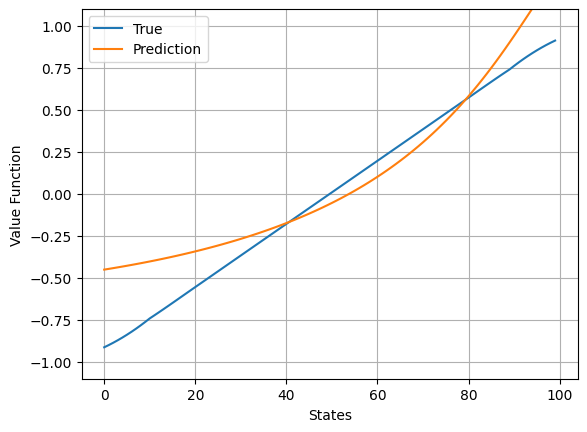

In [32]:
with open('RandomWalk_100.pickle', 'rb') as file: # load the pre-calculated true values
    v_true = pickle.load(file)

# Get the values for all states from the agent
V = np.zeros(env.observation_space.n)
for i in range(0, len(V)):
    V[i] = agent.value(i)
    
plt.plot(v_true[1:-1],label='True')
plt.plot(V[1:-1],label='Prediction')
plt.grid(True)
plt.xlabel('States')
plt.ylabel('Value Function')
plt.ylim(-1.1, 1.1)
plt.legend()
plt.show()

## 3.4 Discussions  <a id="sec3_4">

We will now compare our results with the ones in Figure 9.5. Nevertheless, note that we  should not expect to obtain exactly the same results as the book. In particular, note the following: i) We do not have any averaging over multiple runs, hence there is considerable randomness in our results. (Hence, after your first experiments, changing the code to average over multiple runs can be a good idea )  ii) Our corridor is a scaled-down version of the one in the book. 


__Task-PD1__:   An important aspect is the definition of $\overline{VE}$ in the book, see Eqn 9.1, which we try to minimize. A typical realization of the state distribution under a random agent can be seen in Figure 9.1. According to the Figure 9.1, the value function estimates of which states affect $\overline{VE}$ more? State whether you think this is a good way of defining the error.  

__Task-PD2__:   Relate $\overline{VE}$ with  $E_\pi[(v_\pi(S)−\hat{v}(S,w))^2]$ defined in the lecture slides.

__Task-PD3__:   Repeat the experiment with Fourier basis and Polynomial basis with the order of 5, 10 and 20  multiple times.  In terms of the general trends, are the results consistent with Figure 9.5? In particular, check the following: 
<ul>
<li> The book states that polynomials do not provide satisfactory results in RL tasks. The results in Figure 9.5 support this claim: Fourier basis shows better performance than polynomials. Are our results consistent with these claims? </li>
<li> Do  higher orders provide significantly better predictions?</li>
</ul>

__Task-PD4__: Run the usual MC agent without function approximation using the option `method = 'Tabular'`. How does the value function prediction found in this case compare with the predictions using approximation? Which method(s) are *better*? Do your conclusions depend on the length of the corridor and the maximum allowed movement? 



# 4. On-Policy Control with Function Approximation <a id="sec4">

We now look at the control problem using the function approximation of the the action-value function $\hat{q}(s,a,w)$ with the aim of obtaining $\hat{q}(s,a,w) \approx q_*(s,a)$. 

The updates of the weights for the estimate $\hat{q}$ is given in equation (10.1) in the textbook, and is

$$ w_{t+1} = w_t + \alpha [U_t - \hat{q}(S_t, A_t, w_t)] \nabla \hat{q}(S_t, A_t, w_t)$$
    
We will refer to this equation as Eqn 10.1 below. 

## 4.1 Linear Approximation with Tile Coding <a id="sec4_1">

We now implement a linear approximator that uses tile coding. Since tile coding operates in a slightly different manner than Fourier basis/polynomial, we provide a new linear approximator class for ease of exposition. Note that here each feature $x_i(s,a)$ is binary, i.e., it is either 0 or 1. We say that the feature is _active_ if it is 1. 

This means that we only need to know what indices of $x(s,a)$ that are active for each state-action pair. To implement this we use `TileCoding.py`.
See Section 9.5.4 of the book and  http://incompleteideas.net/tiles/tiles3.html for details. 
    
__Task-TC1:__ Examine the usage of tile coding and make sure that you understand how we use the indices of active tiles as features. In particular, check the method `indicesActiveTiles`.

__Task-TC2:__ Consider the method `value`. Verify that this method gives the approximation $\hat{q}(s,a, w) = \sum_{i} w_i x_i(s,a)$. 

__Task-TC3:__ Tile coding is just another set of features. Explain why the `value` method looks different than the one for Fourier basis and polynomials.  
    
__Task-TC4:__ Complete the `update` function using Eqn 10.1. Note that this `update` function may look different than the `update` function we had for Fourier basis and polynomials. 


In [33]:
class LinearApproximatorTile:
    def __init__(self, nTiling=8, size=4096, alpha=0.3, stateRange=1):
        self.size = size
        self.nTiling = nTiling
        self.iht = tc.IHT(size)
        self.weights = np.zeros(size) 
        self.alpha = alpha
        self.stateRange = stateRange

        # scaling for the states, see ``Fleshing out the example" section on http://incompleteideas.net/tiles/tiles3.html
        # For the mountain-car example also see footnote 1 on page 246 of SuttonBarto_2018
        scaleFactor = self.nTiling
        self.scale = [scaleFactor / s for s in self.stateRange]

    # get indices of active tiles (i.e features)
    def indicesActiveTiles(self, state, action):
        scaledState = [s * scale for s, scale in zip(state, self.scale)]
        return tc.tiles(self.iht, self.nTiling, scaledState, [action])

    # calculate q_app(state, action)
    def value(self, state, action):
        ind = self.indicesActiveTiles(state, action)
        return np.sum(self.weights[ind])

    # update the weights 
    def update(self, target, state, action): # update the weights using  Eqn 10.1
        features = np.zeros(self.size) 
        for i in self.indicesActiveTiles(state, action): 
            features[i] = 1 
        self.weights = self.weights + self.alpha*(target - self.value(state, action))*features 


## 4.2 SARSA for Estimating Action-Value Function with Function Approximation <a id="sec4_2">

The following class implements the algorithm *Episodic semi-gradient Sarsa for estimating $q_*$*  on page 244 of the book. You can also look at the algorithm from the lecture slides of Lecture 7.

**Task-Sarsa:** Complete the `learn` method. 


***Note***: With function approximation we have to handle the case when $S_{t+1}$ is terminal as a special case. When we used tabular methods, we set the initial value of any terminal state to 0, and then we never updated it, so it would always be zero and there for $Q(S_{t+1}, A_{t+1}) = 0$ if $S_{t+1}$ is a terminal state. However, now when we use function approximation this is not true anymore, since changes in $w$ also affect the estimated value of the terminal states. Hence, the target in the update should be 

$$
U_t = \begin{cases} R_{t+1} & \text{if } S_{t+1} \text{ is terminal} \\ R_{t+1} + \gamma \hat{v}(S_{t+1},A_{t+1},w) & \text{otherwise}\end{cases}
$$

To be able to do this, we also pass the flag `terminated` to `learn`. So if `terminated == True` then `state_next` is a terminal state.

In [34]:
class SARSA:
    def __init__(self, gamma, epsilon, alpha, stateRange):
        self.n_actions = 3  # 0,1,2:  reverse, stay, go forward
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.func_approx = LinearApproximatorTile(nTiling=8, size=4096, alpha=alpha, stateRange=stateRange)

    def act(self, state): 
        if np.random.random_sample() <= self.epsilon:  # random action wp epsilon  
            action = np.random.choice(np.arange(0,self.actions))
        else:  # greedy action wp 1-epsilon
            # Get all action values
            Q = np.zeros(self.n_actions)
            for action in range(0, self.n_actions):
                Q[action] = self.func_approx.value(state, action)
                
            # Take greedy action, and choose randomly when there is a tie
            a_max = np.where(Q == np.max(Q))[0]
            action = np.random.choice(a_max) 
        return action


    # Sutton, Barton pg.244
    def learn(self, state, action, reward, state_next, action_next, terminated): 
        # TODO-STD Implement the weight updates according to Sarsa pseudo-code on page 244
        
        if terminated:  
            self.func_approx.update(reward, state, action) 
        else: 
            self.func_approx.update(reward + self.gamma*self.func_approx.value(state_next, action_next), state, action) 


We now introduce the training function, and also a test function where you can test your trained agents policy.

In [35]:
def train(env, agent, nEpisode):
    total_reward_episodes = np.zeros(nEpisode)
    max_nStep = 1000
    print('Run starts')
    for iEpisode in range(nEpisode):
        if iEpisode % 50 == 0:
            print('Episode', iEpisode)
        terminated, truncated = False, False
        t = 0
        state, info = env.reset()
        action = agent.act(state)
        rewardA = [0]
        while not terminated and not truncated:
            state_next, reward, terminated, truncated, info = env.step(action) 
            action_next = agent.act(state_next)
            agent.learn(state, action, reward, state_next, action_next, terminated)
            action = action_next
            state  = state_next
            t += 1
            if t > max_nStep:
                truncated = True
                
            total_reward_episodes[iEpisode] += reward

    print('Finished')
    return total_reward_episodes

def test_car(agent, env, render=True): 
    state, info = env.reset()
    step = 0
    total_reward = 0
    terminated = False
    truncated = False
    while not terminated and not truncated:
        action = agent.act(state)
        state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        step += 1
        
        if render:
            clear_output(wait=True)
            env.render()
            # Show some information
            print("Time step:", step)
            print("Reward:", reward)
            print("Total reward:", total_reward)
    return total_reward

## 4.3 The MountainCar Environment <a id="sec4_3">

We will test our SARSA-agent with function approximation on the `MountainCar-v0` environment you have seen in previous notebooks. The environment is also described in Example 10.1 of the textbook. 

Let us first look at the environment

In [36]:
env = gym.make('MountainCar-v0', render_mode="human")
print("State space:", env.observation_space)
print("Action space:", env.action_space)

state, info = env.reset()
print("Initial state:", state)

State space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Action space: Discrete(3)
Initial state: [-0.57187265  0.        ]


The state space is continuous, and the first element corresponds to the position of the car, while the second element corresponds to the velocity of the car. We can see that the position can go between -1.2 and 0.6, while the velocity is between -0.07 and 0.07. We will use this information to re-scale the sate in in the linear function approximator. 

To prepare for training, we create a new environment `env_train` that does not render. Furthermore, the `MountainCar-v0` has as a standard a time limit that truncates the episode if the car did not reach the goal within 200 steps. To be able to compare with Example 10.1 in the textbook, we do not want this artificial time limit (see in Figure 10.2 that the first episode used more than 1000 time steps). Therefore we ad `.env` when we create the environment, since this will remove the time limit wrapper.

In [37]:
env_train = gym.make('MountainCar-v0').env

# state limits for Mountain-Car Environment
min_position = -1.2
max_position = 0.6  
max_velocity = 0.07
min_velocity = -0.07
stateRange = [max_position - min_position, max_velocity - min_velocity]

agent = SARSA(gamma=1, epsilon=0, alpha=0.5/8, stateRange=stateRange)

We now train. __Note that training may take some time, wait until you see 'Finished'.__

In [38]:
total_reward_episodes = train(env_train, agent, nEpisode = 500)

Run starts
Episode 0
Episode 50
Episode 100
Episode 150
Episode 200
Episode 250
Episode 300
Episode 350
Episode 400
Episode 450
Finished


We can now plot the number of of time steps each episode during training took. You can compare this with Figure 10.2 in the textbook. 

Note that the number of time steps is `-total_reward` since the reward in each time step is -1.

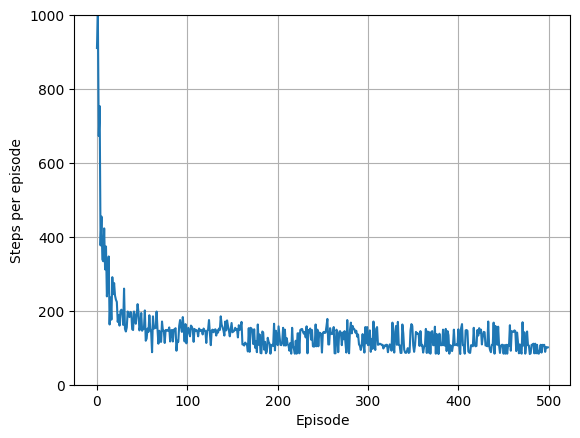

In [39]:
plt.plot(-total_reward_episodes)
plt.xlabel('Episode')
plt.ylabel('Steps per episode')
plt.ylim(0, 1000)
plt.grid(True)
plt.show()

And if you want to see your agent in action you can use:

In [40]:
test_car(agent, env)

Time step: 155
Reward: -1.0
Total reward: -155.0


-155.0

## 4.4 Discussions <a id="sec4_4">

We now compare our results with the figures in the book. Similar to the before, note the following: in this notebook we do not perform averaging over runs hence we typically have more randomness in our results compared to the book. We should keep this point in mind while interpreting our results. You are encouraged  to perform averaging over the runs after your initial experiments.

__Task-CD1:__  Consider Figure 10.2 which shows how the episode length varies with different learning rates as the agent trains. Try different $\alpha$ values for the agent. Do you observe the same type of behaviour? Explain the reason behind the general trend as $\alpha$ increases/decreases. 

__Task-CD2:__ It may also be interesting to go back to Tinkering Notebook 3b, where you tested to solve `MountainCar-v0` using state aggregation, and compare the results with using tile coding.